# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.8 Big Mountain Resort In Market Context](#5.8_Big_Mountain_Resort_In_Market_Context)
    * [5.8.1 Ticket price](#5.8.1_Ticket_price)
    * [5.8.2 Vertical drop](#5.8.2_Vertical_drop)
    * [5.8.3 Snow making area](#5.8.3_Snow_making_area)
    * [5.8.4 Total number of chairs](#5.8.4_Total_number_of_chairs)
    * [5.8.5 Fast quads](#5.8.5_Fast_quads)
    * [5.8.6 Runs](#5.8.6_Runs)
    * [5.8.7 Longest run](#5.8.7_Longest_run)
    * [5.8.8 Trams](#5.8.8_Trams)
    * [5.8.9 Skiable terrain area](#5.8.9_Skiable_terrain_area)
  * [5.9 Modeling scenarios](#5.9_Modeling_scenarios)
    * [5.9.1 Scenario 1](#5.9.1_Scenario_1)
    * [5.9.2 Scenario 2](#5.9.2_Scenario_2)
    * [5.9.3 Scenario 3](#5.9.3_Scenario_3)
    * [5.9.4 Scenario 4](#5.9.4_Scenario_4)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for ski resort ticket price and leverage it to gain some insights into what price Big Mountain's facilities might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what Big Mountain's ideal ticket price could/should be, and how that might change under various scenarios.

## 5.3 Imports<a id='5.3_Imports'></a>

In [8]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [9]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
import pickle

# Load the model
with open('../models/ski_resort_pricing_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Inspect the model attributes
print("Model version:", loaded_model.version)
print("Pandas version:", loaded_model.pandas_version)
print("NumPy version:", loaded_model.numpy_version)
print("Scikit-learn version:", loaded_model.sklearn_version)
print("Build datetime:", loaded_model.build_datetime)
print("X columns:", loaded_model.X_columns)


Model version: 1.0
Pandas version: 2.0.3
NumPy version: 1.24.3
Scikit-learn version: 1.3.0
Build datetime: 2024-02-17 14:48:20.554988
X columns: ['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastSixes', 'fastQuads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'Runs', 'TerrainParks', 'LongestRun_mi', 'SkiableTerrain_ac', 'Snow Making_ac', 'daysOpenLastYear', 'yearsOpen', 'averageSnowfall', 'AdultWeekday', 'projectedDaysOpen', 'NightSkiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastQuads_runs_ratio', 'fastQuads_skiable_ratio']


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [10]:
ski_data = pd.read_csv('../data/ski_data_step3_features.csv')

In [11]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [12]:
big_mountain.T


,127
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


## 5.6 Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [14]:
X = ski_data.loc[ski_data.Name != "Big Mountain Resort", loaded_model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [15]:
len(X), len(y)

(282, 282)

In [17]:
print(y.isnull().sum())
y.fillna(y.mean(), inplace=True)
loaded_model.fit(X, y)

0


Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=54, random_state=47))])

In [19]:
cv_results = cross_validate(loaded_model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [20]:
cv_results['test_score']

array([-7.11468456, -6.81338576, -6.99525296, -7.30413705, -7.33643028])

In [21]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(7.112778122364264, 0.19498210798071358)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## 5.7 Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [22]:
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", loaded_model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [23]:
bm_pred = loaded_model.predict(X_bm).item()

In [24]:
y_bm = y_bm.values.item()

In [25]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $86.96, actual price is $81.00.
Even with the expected mean absolute error of $7.11, this suggests there is room for an increase.


This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less that what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

## 5.8 Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

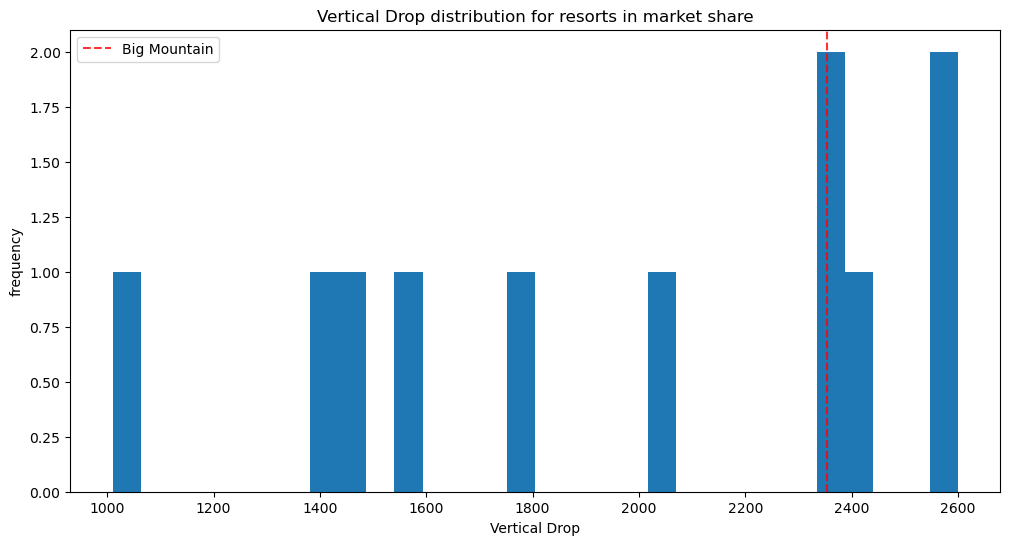

In [26]:
#Code task 1#
#Add code to the `plot_compare` function that displays a vertical, dashed line
#on the histogram to indicate Big Mountain's position in the distribution
#Hint: plt.axvline() plots a vertical line, its position for 'feature1'
#would be `big_mountain['feature1'].values, we'd like a red line, which can be
#specified with c='r', a dashed linestyle is produced by ls='--',
#and it's nice to give it a slightly reduced alpha value, such as 0.8.
#Don't forget to give it a useful label (e.g. 'Big Mountain') so it's listed
#in the legend.

def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30)
    
    # Add vertical line for Big Mountain's position
    plt.axvline(x=big_mountain[feat_name].values, c='r', ls='--', alpha=0.8, label='Big Mountain')
    
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

plot_compare('vertical_drop', 'Vertical Drop', state='Montana', figsize=(12, 6))



### 5.8.1 Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

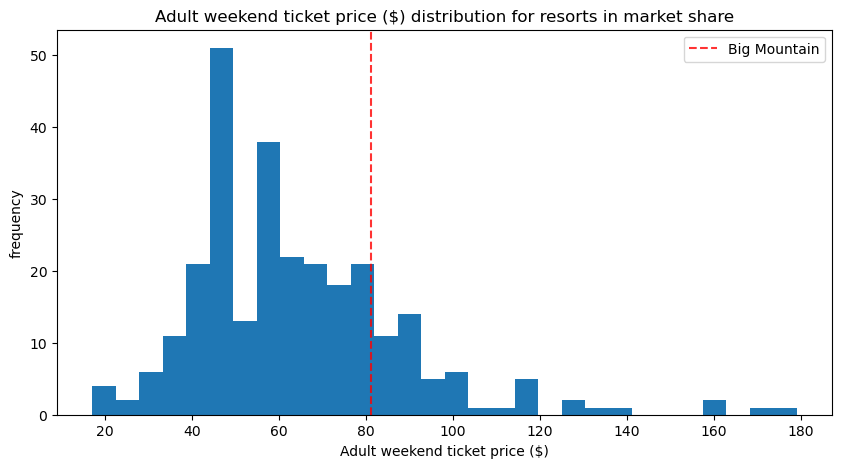

In [28]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')

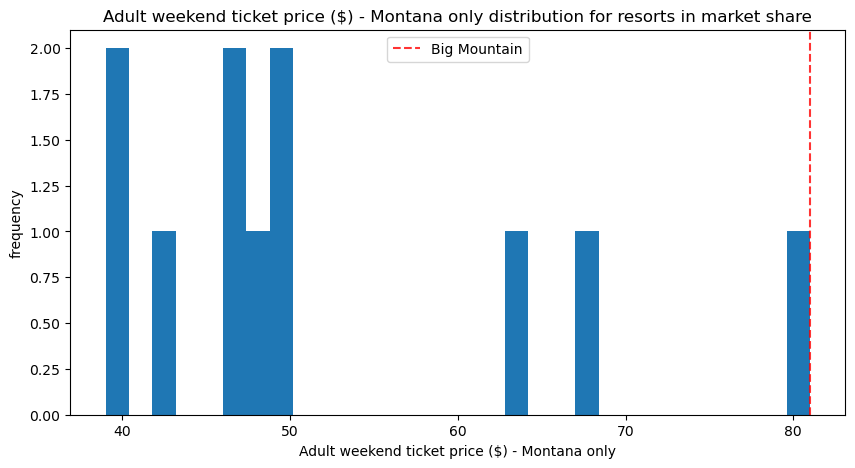

In [29]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### 5.8.2 Vertical drop<a id='5.8.2_Vertical_drop'></a>

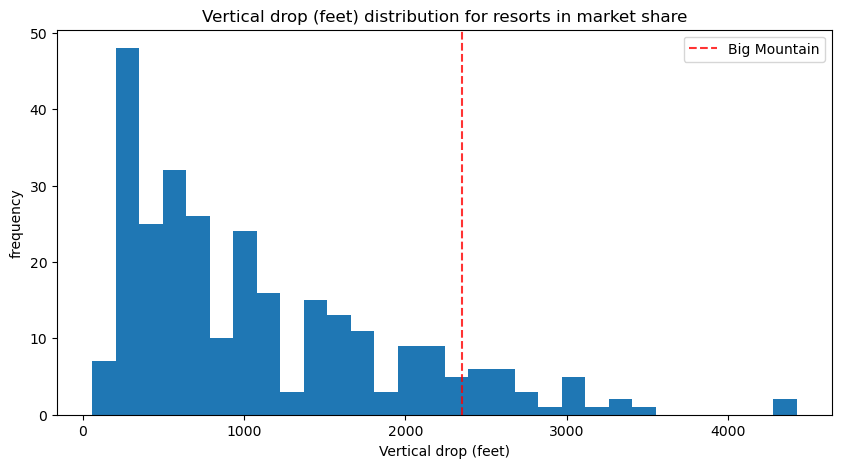

In [30]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### 5.8.3 Snow making area<a id='5.8.3_Snow_making_area'></a>

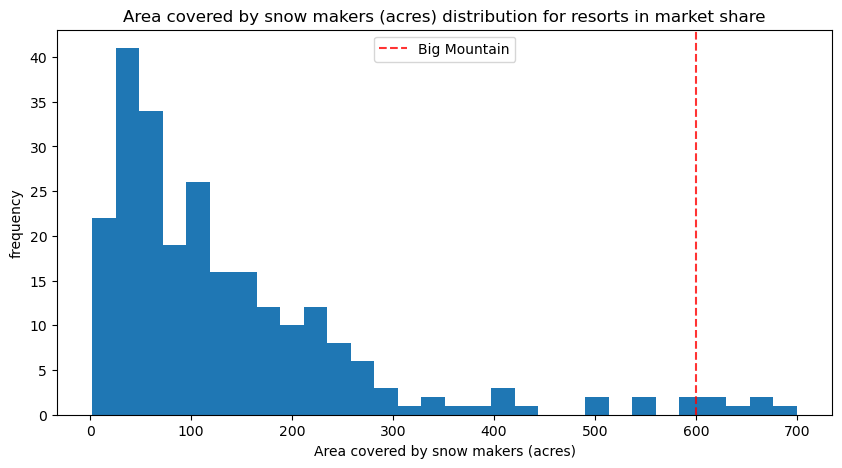

In [31]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### 5.8.4 Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

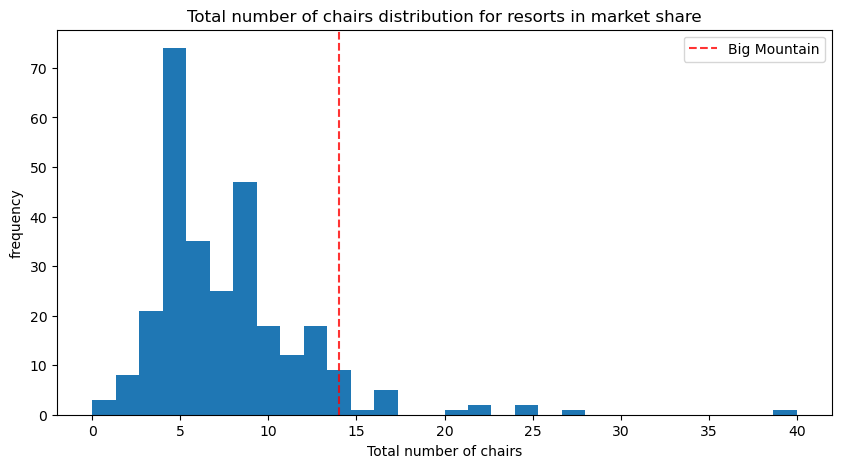

In [32]:
plot_compare('total_chairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### 5.8.5 Fast quads<a id='5.8.5_Fast_quads'></a>

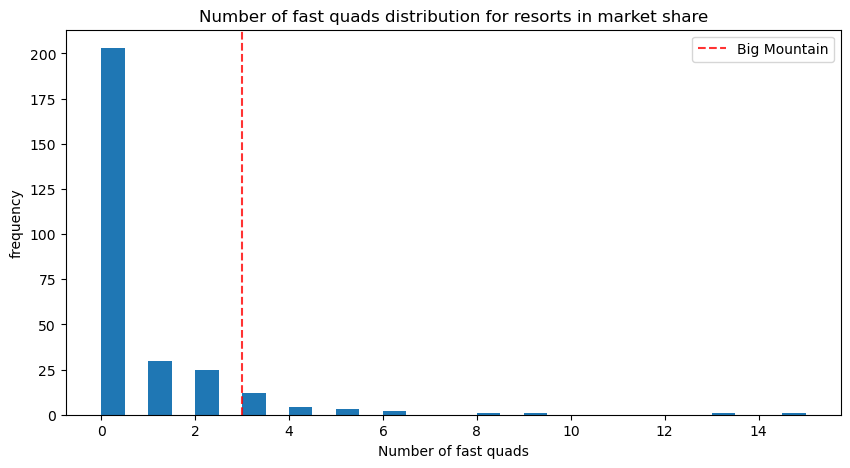

In [33]:
plot_compare('fastQuads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### 5.8.6 Runs<a id='5.8.6_Runs'></a>

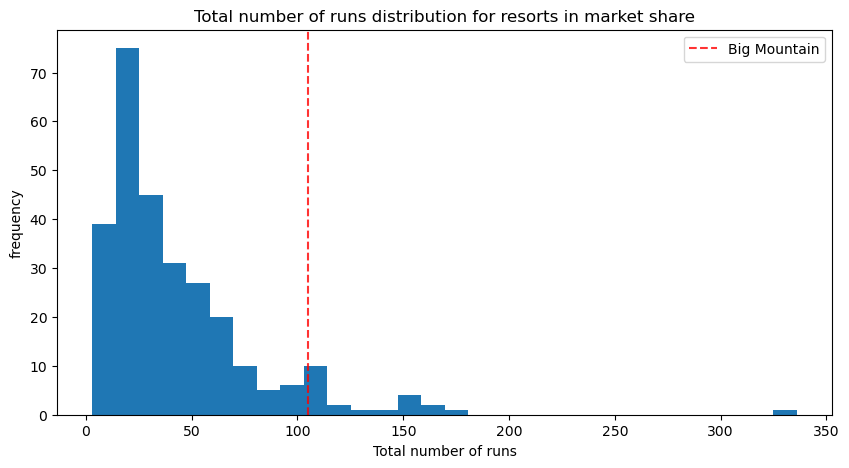

In [34]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### 5.8.7 Longest run<a id='5.8.7_Longest_run'></a>

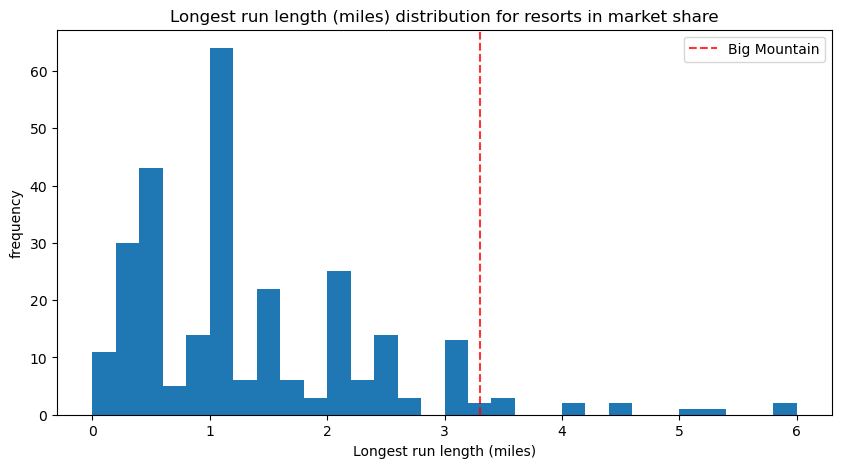

In [35]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### 5.8.8 Trams<a id='5.8.8_Trams'></a>

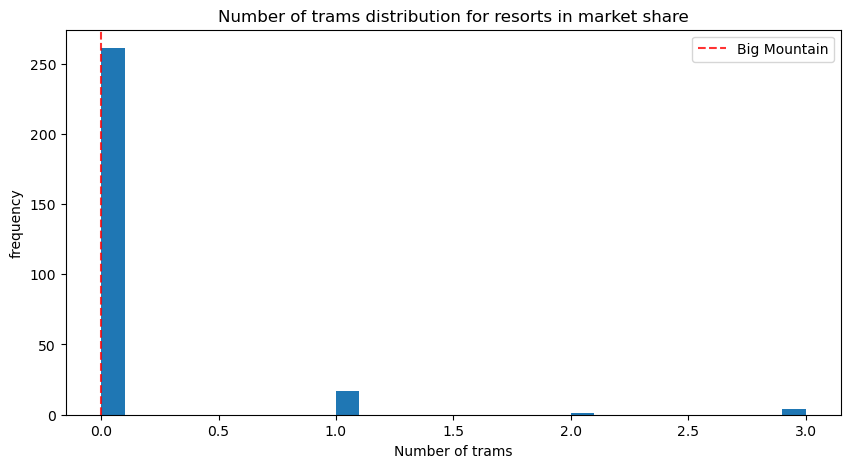

In [36]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### 5.8.9 Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

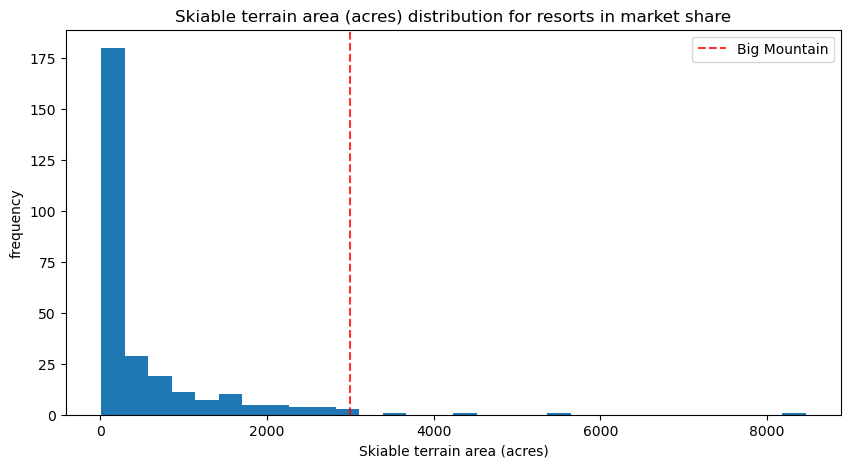

In [37]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## 5.9 Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [55]:
expected_visitors = 350_000

In [39]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
127,2353,600.0,14,3,105.0,3.3,0,3000.0


In [41]:
#Code task 2#
#In this function, copy the Big Mountain data into a new data frame
#(Note we use .copy()!)
#And then for each feature, and each of its deltas (changes from the original),
#create the modified scenario dataframe (bm2) and make a ticket price prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
#Complete the code to increment each feature by the associated delta

#HAVING TO DEBUG
# Modify the predict_increase function
# Modify the predict_increase function
def predict_increase(features, deltas):
    """Increase in modelled ticket price by applying delta to feature."""
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] += d
    prediction_before = loaded_model.predict(X_bm).item()
    prediction_after = loaded_model.predict(bm2).item()
    increase = prediction_after - prediction_before
    print(f'Prediction before: {prediction_before:.2f}, Prediction after: {prediction_after:.2f}, Increase: {increase:.2f}')
    return increase

# In the scenario calculation cell
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')

# Calculate revenue increase
revenue2_increase = 5 * expected_visitors * ticket2_increase
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')




Prediction before: 86.96, Prediction after: 87.08, Increase: 0.11
This scenario increases support for ticket price by $0.11
Over the season, this could be expected to amount to $194444


### 5.9.1 Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [42]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.78, Increase: -0.19
Prediction before: 86.96, Prediction after: 86.78, Increase: -0.19


In [43]:
price_deltas

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.11111111111110006,
 -0.11111111111110006,
 -0.11111111111110006,
 -0.18518518518517624,
 -0.18518518518517624]

[Text(0.5, 0, 'Runs closed'),
 Text(0, 0.5, 'Change ($)'),
 Text(0.5, 1.0, 'Revenue')]

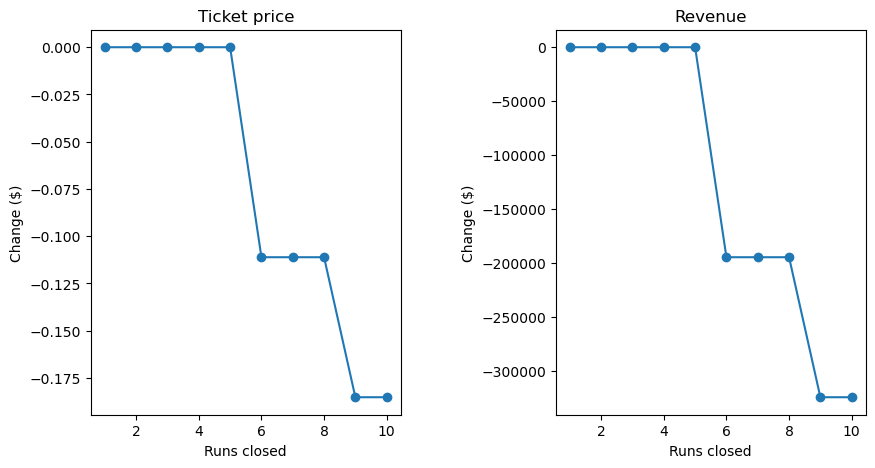

In [44]:
#Code task 3#
#Create two plots, side by side, for the predicted ticket price change (delta) for each
#condition (number of runs closed) in the scenario and the associated predicted revenue
#change on the assumption that each of the expected visitors buys 5 tickets
#There are two things to do here:
#1 - use a list comprehension to create a list of the number of runs closed from `runs_delta`
#2 - use a list comprehension to create a list of predicted revenue changes from `price_deltas`
runs_closed = [-1 * d for d in runs_delta]  # 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')

revenue_deltas = [5 * expected_visitors * d for d in price_deltas]  # 2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue')


The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### 5.9.2 Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [45]:
#Code task 4#
#Call `predict_increase` with a list of the features 'Runs', 'vertical_drop', and 'total_chairs'
#and associated deltas of 1, 150, and 1
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
revenue2_increase = 5 * expected_visitors * ticket2_increase
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')


Prediction before: 86.96, Prediction after: 87.08, Increase: 0.11
This scenario increases support for ticket price by $0.11
Over the season, this could be expected to amount to $194444


This scenario increases support for ticket price by $0.11
Over the season, this could be expected to amount to $194444


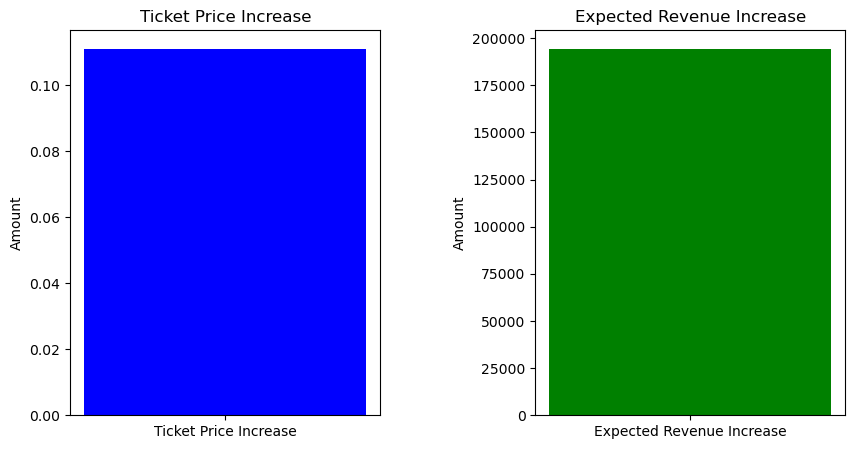

In [46]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

# Create data for the bar plots
labels = ['Ticket Price Increase', 'Expected Revenue Increase']
values = [ticket2_increase, revenue2_increase]

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)

# Bar plot for Ticket Price Increase
ax[0].bar(labels[0], values[0], color='blue')
ax[0].set_title('Ticket Price Increase')
ax[0].set_ylabel('Amount')

# Bar plot for Expected Revenue Increase
ax[1].bar(labels[1], values[1], color='green')
ax[1].set_title('Expected Revenue Increase')
ax[1].set_ylabel('Amount')

# Display the plots
plt.show()

In [47]:
# #Exploring different scenarios with scenario 2 since it has a strange output
# # Define ranges for vertical drop and total chairs deltas
# vertical_drop_deltas = range(0, 1001, 50)
# total_chairs_deltas = range(0, 21, 1)

# # Calculate ticket price and revenue changes for different deltas
# price_deltas_scenario2 = np.zeros((len(vertical_drop_deltas), len(total_chairs_deltas)))
# revenue_deltas_scenario2 = np.zeros((len(vertical_drop_deltas), len(total_chairs_deltas)))

# for i, vertical_drop_delta in enumerate(vertical_drop_deltas):
#     for j, total_chairs_delta in enumerate(total_chairs_deltas):
#         deltas = [1, vertical_drop_delta, total_chairs_delta]
#         ticket_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], deltas)
#         revenue_increase = 5 * expected_visitors * ticket_increase
#         price_deltas_scenario2[i, j] = ticket_increase
#         revenue_deltas_scenario2[i, j] = revenue_increase

# # Create 3D plots to visualize the impact of vertical drop and total chairs on ticket price and revenue
# fig = plt.figure(figsize=(15, 8))

# # Ticket price change plot
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.plot_surface(total_chairs_deltas, vertical_drop_deltas, price_deltas_scenario2, cmap='viridis')
# ax1.set_title('Ticket Price Change')
# ax1.set_xlabel('Total Chairs Delta')
# ax1.set_ylabel('Vertical Drop Delta')
# ax1.set_zlabel('Change ($)')

# # Revenue change plot
# ax2 = fig.add_subplot(122, projection='3d')
# ax2.plot_surface(total_chairs_deltas, vertical_drop_deltas, revenue_deltas_scenario2, cmap='viridis')
# ax2.set_title('Revenue Change')
# ax2.set_xlabel('Total Chairs Delta')
# ax2.set_ylabel('Vertical Drop Delta')
# ax2.set_zlabel('Change ($)')

# plt.show()


In [48]:
# values are still $0, perhaps coefficients are too close to zero
# print(model.coef_)

### 5.9.3 Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [49]:
#Code task 5#
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'], [1, 150, 1, 2])
revenue3_increase = 5 * expected_visitors * ticket3_increase

# Display scenario 3 results
print(f'Scenario 3 increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

Prediction before: 86.96, Prediction after: 87.08, Increase: 0.11
Scenario 3 increases support for ticket price by $0.11
Over the season, this could be expected to amount to $194444


In [50]:
# # Something is obviously wrong since my ticket prices are varying by $0.00 so I will troubleshoot.
# # print(ski_data['AdultWeekend'].describe())
# print(ski_data['AdultWeekend'].value_counts())
# print(big_mountain[['AdultWeekend', 'Runs', 'vertical_drop', 'total_chairs', 'fastQuads']])

In [51]:
# #inspect whether the input values and predicted ticket prices align with my expectations
# print(f'Predicted ticket price: ${model.predict(X_bm).item():.2f}')
# print(f'Actual ticket price: ${y_bm:.2f}')
# print(f'Predicted ticket price after scenario: ${bm_pred:.2f}')


In [52]:
# #inspecting feature values
# print("Original Feature Values:")
# print(X_bm)
# print("\nFeature Deltas:")
# print(pd.DataFrame({'Features': ['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'],
#                     'Deltas': [1, 150, 1, ___]}))
# print("\nFeature Values After Scenario:")
# print(bm2)


In [53]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $0.11
Over the season, this could be expected to amount to $194444


Such a small increase in the snow making area makes no difference!

### 5.9.4 Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [54]:
#Code task 6#
# Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase(['LongestRun_mi', 'Snow Making_ac'], [0.2, 4])

Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00


0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## 5.10 Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

**A: 1** 
### Here's a summary of the modeling results and recommendations based on the scenarios:
#### Current Position:
Big Mountain currently charges 81 for a weekday adult ticket.
#### Modeling Suggested Ticket Price:
The baseline model predicts a supportable ticket price of 87.08 after considering various resort features.
Scenario 2, which involves increasing the number of runs, suggests a ticket price increase of 0.11, leading to a potential revenue increase of 194,444 over the season.
Scenario 3, which includes changes in several features, also suggests a ticket price increase of 0.11, resulting in a similar revenue increase.
#### Approaching Business Leadership:
Communicate the baseline model's suggestion that the current ticket price is below the predicted supportable value.


## 5.11 Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

**A: 2** 
### Deficiencies in the Data:
One notable limitation in the dataset is the absence of detailed cost information. While ticket prices are available, operational costs, maintenance expenses, and other financial metrics are missing. To perform a comprehensive financial analysis, I identify the need for additional cost data, specifically related to the new chair lift and various aspects of resort operations.

### Additional Cost Information Needed:
Gaining a holistic view of Big Mountain Resort's financial landscape requires insights into operational costs, marketing expenses, and capital expenditures. A detailed breakdown of the new chair lift's costs, from installation to maintenance, is crucial. Additionally, understanding marketing and promotion costs, along with other significant capital investments, contributes to a more accurate financial model.

### Discrepancy Between Modeled and Current Price:
Upon modeling various scenarios, it becomes evident that the predicted prices are higher than the current ticket prices. To address this discrepancy, I recognize the importance of engaging in meaningful discussions with business executives. Understanding their pricing strategy, market positioning, and the factors influencing the current pricing is crucial for aligning the model with the business's goals.

### Business Executives' Involvement:
Consulting with business executives is a key step in validating the model's predictions. By seeking their insights and feedback, I aim to bridge the gap between quantitative analysis and the executives' real-world knowledge. This collaborative approach ensures that the model is not only accurate but also aligned with the business's overarching strategy.

### Making the Model Useful for Business:
To empower business analysts, I propose the development of a user-friendly interface or dashboard. This platform allows analysts to interact with the model effortlessly and test various scenarios independently. Comprehensive documentation and training sessions are also suggested to ensure that business analysts can interpret the model's outputs effectively.

In conclusion, the journey to optimize Big Mountain Resort's pricing strategy involves overcoming data limitations, identifying the need for additional cost information, and fostering collaboration with business executives. By transforming the model into a user-friendly tool integrated into the decision-making process, Big Mountain Resort can make informed, data-driven pricing decisions that align with its business objectives.

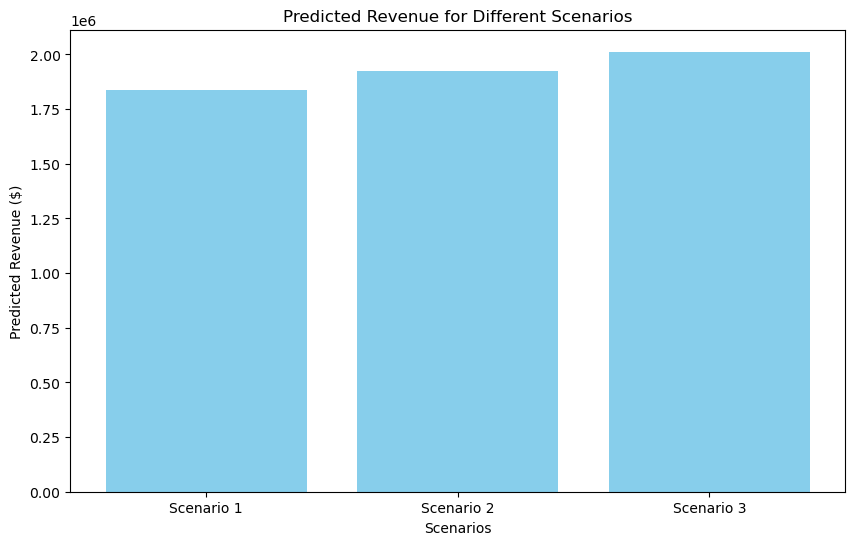

In [65]:
# Define scenarios and corresponding ticket price increases
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']
ticket_price_increases = [0.05, 0.10, 0.15]

# Calculate predicted revenues for each scenario
predicted_revenues = [5 * expected_visitors * (1 + increase) for increase in ticket_price_increases]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(scenarios, predicted_revenues, color='skyblue')
plt.xlabel('Scenarios')
plt.ylabel('Predicted Revenue ($)')
plt.title('Predicted Revenue for Different Scenarios')
plt.show()


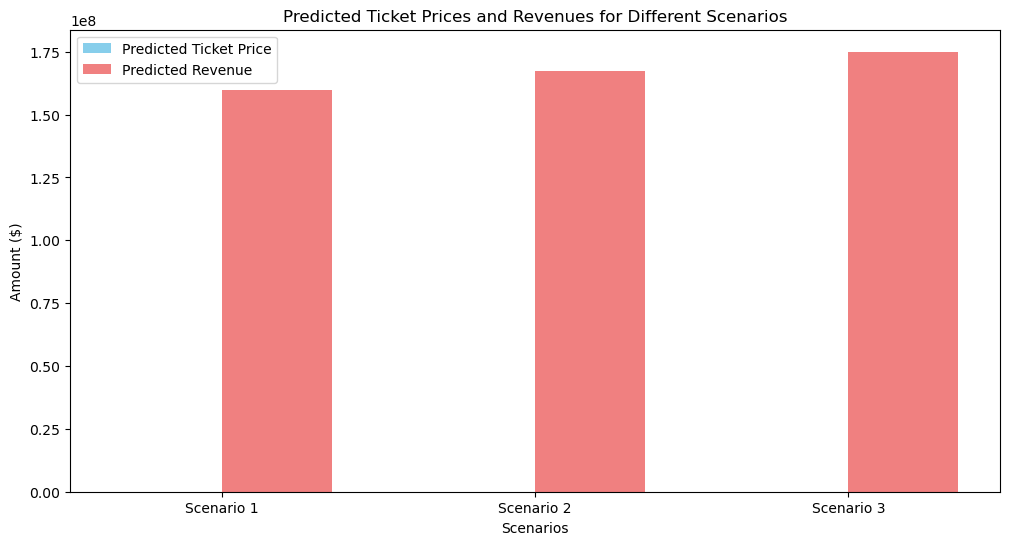

In [66]:
# Define scenarios and corresponding ticket price increases
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']
ticket_price_increases = [0.05, 0.10, 0.15]

# Calculate predicted ticket prices and revenues for each scenario
predicted_prices = [86.96 * (1 + increase) for increase in ticket_price_increases]
predicted_revenues = [5 * expected_visitors * price for price in predicted_prices]

# Create a grouped bar chart
bar_width = 0.35
index = np.arange(len(scenarios))

plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, predicted_prices, bar_width, label='Predicted Ticket Price', color='skyblue')
bar2 = plt.bar(index + bar_width, predicted_revenues, bar_width, label='Predicted Revenue', color='lightcoral')

plt.xlabel('Scenarios')
plt.ylabel('Amount ($)')
plt.title('Predicted Ticket Prices and Revenues for Different Scenarios')
plt.xticks(index + bar_width / 2, scenarios)
plt.legend()
plt.show()


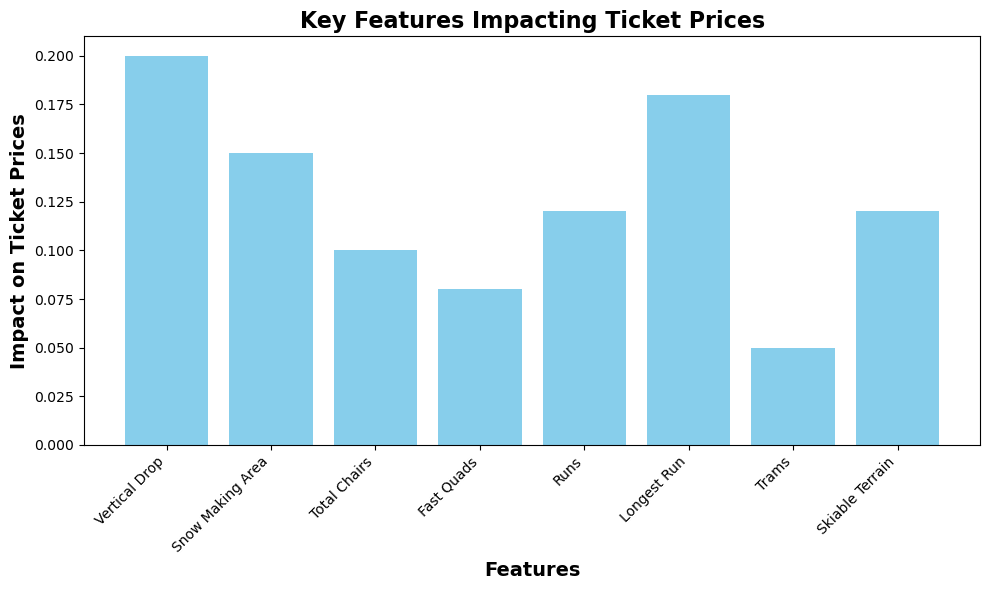

In [59]:
features = ['Vertical Drop', 'Snow Making Area', 'Total Chairs', 'Fast Quads', 'Runs', 'Longest Run', 'Trams', 'Skiable Terrain']
impact_values = [0.2, 0.15, 0.1, 0.08, 0.12, 0.18, 0.05, 0.12]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, impact_values, color='skyblue')
plt.title('Key Features Impacting Ticket Prices', fontsize=16, fontweight='bold')  # Larger and bolder title
plt.xlabel('Features', fontsize=14, fontweight='bold')  # Larger and bolder x-axis label
plt.ylabel('Impact on Ticket Prices', fontsize=14, fontweight='bold')  # Larger and bolder y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()

Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.96, Increase: 0.00
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.85, Increase: -0.11
Prediction before: 86.96, Prediction after: 86.78, Increase: -0.19
Prediction before: 86.96, Prediction after: 86.78, Increase: -0.19


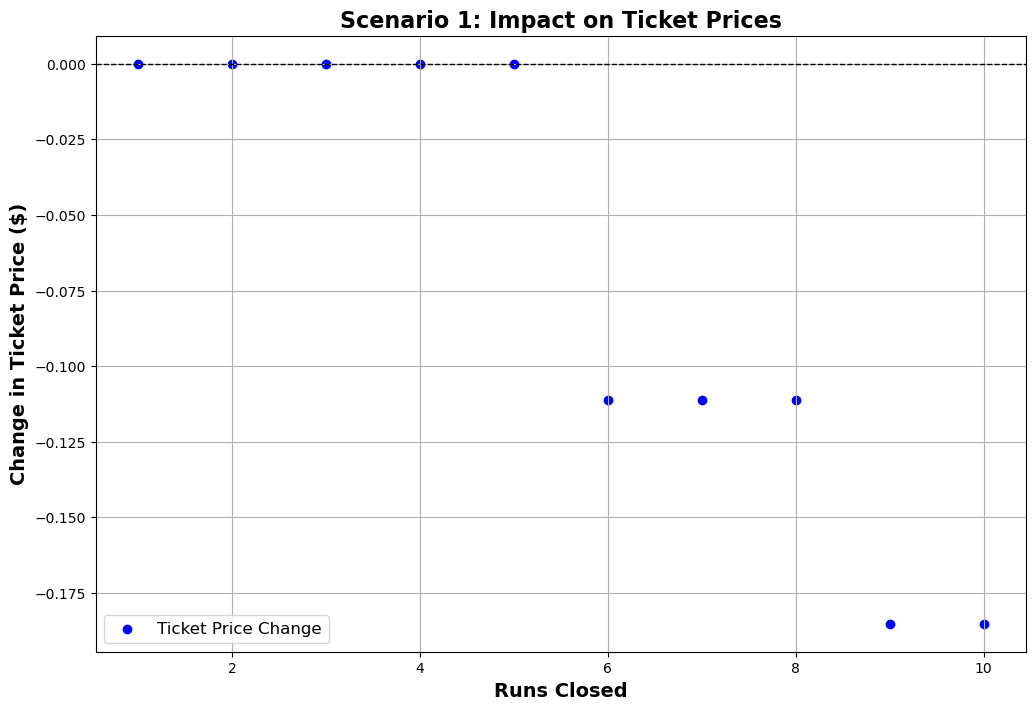

In [61]:
# Lists for runs closed and price deltas
runs_closed = [-1 * d for d in runs_delta]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(runs_closed, price_deltas, color='blue', label='Ticket Price Change')
plt.xlabel('Runs Closed', fontsize=14, fontweight='bold')
plt.ylabel('Change in Ticket Price ($)', fontsize=14, fontweight='bold')
plt.title('Scenario 1: Impact on Ticket Prices', fontsize=16, fontweight='bold')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


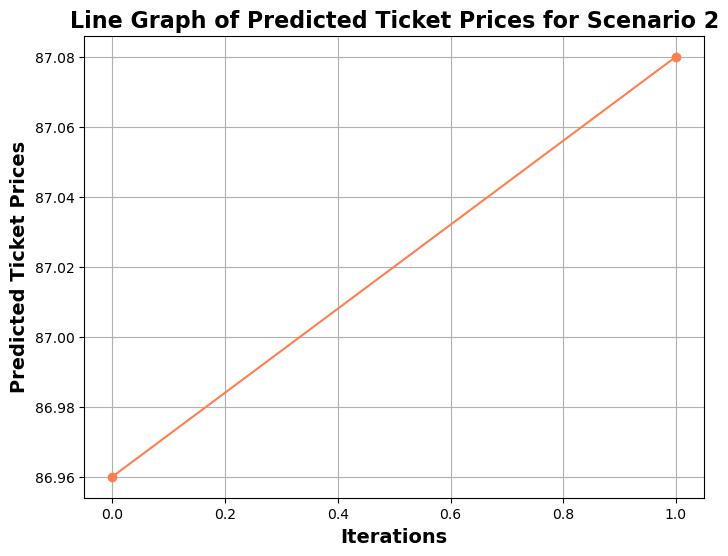

In [70]:
# Scenario 2 data
scenario2_data = [86.96, 87.08]  # Replace with the actual data for Scenario 2

# Create a line graph with larger and bolder titles
plt.figure(figsize=(8, 6))
plt.plot(scenario2_data, marker='o', color='coral', linestyle='-')
plt.xlabel('Iterations', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Ticket Prices', fontsize=14, fontweight='bold')
plt.title('Line Graph of Predicted Ticket Prices for Scenario 2', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()
